Author: Irfan Khan

Place: Helsinki, Finland
    

The goal of this classification problem is to discriminate between different glass types based on the given features. For the available samples having multi features with known classes, intuitively the idea is to predict the class for a new sample. The development of robust and efficient predictve techniques is a two-fold data science approach: (1) exploratory data anaysis (EDA), (2) model selection and evaluation. 

Initial step in data analysis is where the scientist explores a data set to visualize interesting initial patterns and data characteristics. EDA is used to understand the assumptions required to implement a model, the challanges in terms of data complexity and resource availability. Furthermore, appropriate model selection and performance evaluation metric is essential in any data analysis problem.

Data Source: https://archive.ics.uci.edu/ml/datasets/Glass+Identification

Abstract: From USA Forensic Science Service; 6 types of glass; defined in terms of their oxide content (i.e. Na, Fe, K, etc)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

from sklearn.utils import class_weight
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV


from scipy import interp
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_randuni
#from keras.wrappers.scikit_learn import KerasClassifier



import pickle as cpickle

%matplotlib inline
import requests, json

from flask import Flask, abort, jsonify, request
#RANDOM_STATE = 1707

In [2]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [3]:
# load the car data dataset
try:
    data = pd.read_csv("glass.data", delimiter=",", names=['ID', 'RI', 'N','Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'TypeofGlass'], index_col ="ID")
    print(" dataset has {} samples with {} features each.".format(*data.shape))
except:
    print("Dataset could not be loaded. Is the dataset missing?")

 dataset has 214 samples with 10 features each.


In [4]:
data.head()

,RI,N,Mg,Al,Si,K,Ca,Ba,Fe,TypeofGlass
ID,,,,,,,,,,
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [5]:
data.head()

,RI,N,Mg,Al,Si,K,Ca,Ba,Fe,TypeofGlass
ID,,,,,,,,,,
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [6]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
RI,214.0,1.518365,0.003037,1.51115,1.516523,1.51768,1.519157,1.53393
N,214.0,13.407850,0.816604,10.73000,12.907500,13.30000,13.825000,17.38000
Mg,214.0,2.684533,1.442408,0.00000,2.115000,3.48000,3.600000,4.49000
Al,214.0,1.444907,0.499270,0.29000,1.190000,1.36000,1.630000,3.50000
Si,214.0,72.650935,0.774546,69.81000,72.280000,72.79000,73.087500,75.41000
K,214.0,0.497056,0.652192,0.00000,0.122500,0.55500,0.610000,6.21000
Ca,214.0,8.956963,1.423153,5.43000,8.240000,8.60000,9.172500,16.19000
Ba,214.0,0.175047,0.497219,0.00000,0.000000,0.00000,0.000000,3.15000
Fe,214.0,0.057009,0.097439,0.00000,0.000000,0.00000,0.100000,0.51000
TypeofGlass,214.0,2.780374,2.103739,1.00000,1.000000,2.00000,3.000000,7.00000


# Attribute Information:
   1. Id number: 1 to 214
   2. RI: refractive index
   3. Na: Sodium (unit measurement: weight percent in corresponding oxide, as are attributes 4-10)
   4. Mg: Magnesium
   5. Al: Aluminum
   6. Si: Silicon
   7. K: Potassium
   8. Ca: Calcium
   9. Ba: Barium
  10. Fe: Iron
  11. Type of glass: (class attribute)
      -- 1 building_windows_float_processed
      -- 2 building_windows_non_float_processed
      -- 3 vehicle_windows_float_processed
      -- 4 vehicle_windows_non_float_processed (none in this database)
      -- 5 containers
      -- 6 tableware
      -- 7 headlamps

In [7]:
data['TypeofGlass'].value_counts()

2    76
1    70
7    29
3    17
5    13
6     9
Name: TypeofGlass, dtype: int64

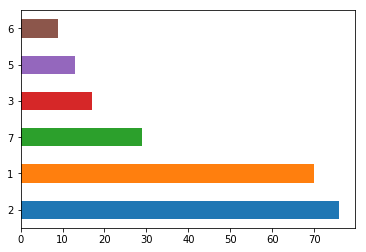

In [8]:
data['TypeofGlass'].value_counts().plot(kind='barh')

In [9]:
data[['RI', 'N','Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']].isnull().mean()

RI    0.0
N     0.0
Mg    0.0
Al    0.0
Si    0.0
K     0.0
Ca    0.0
Ba    0.0
Fe    0.0
dtype: float64

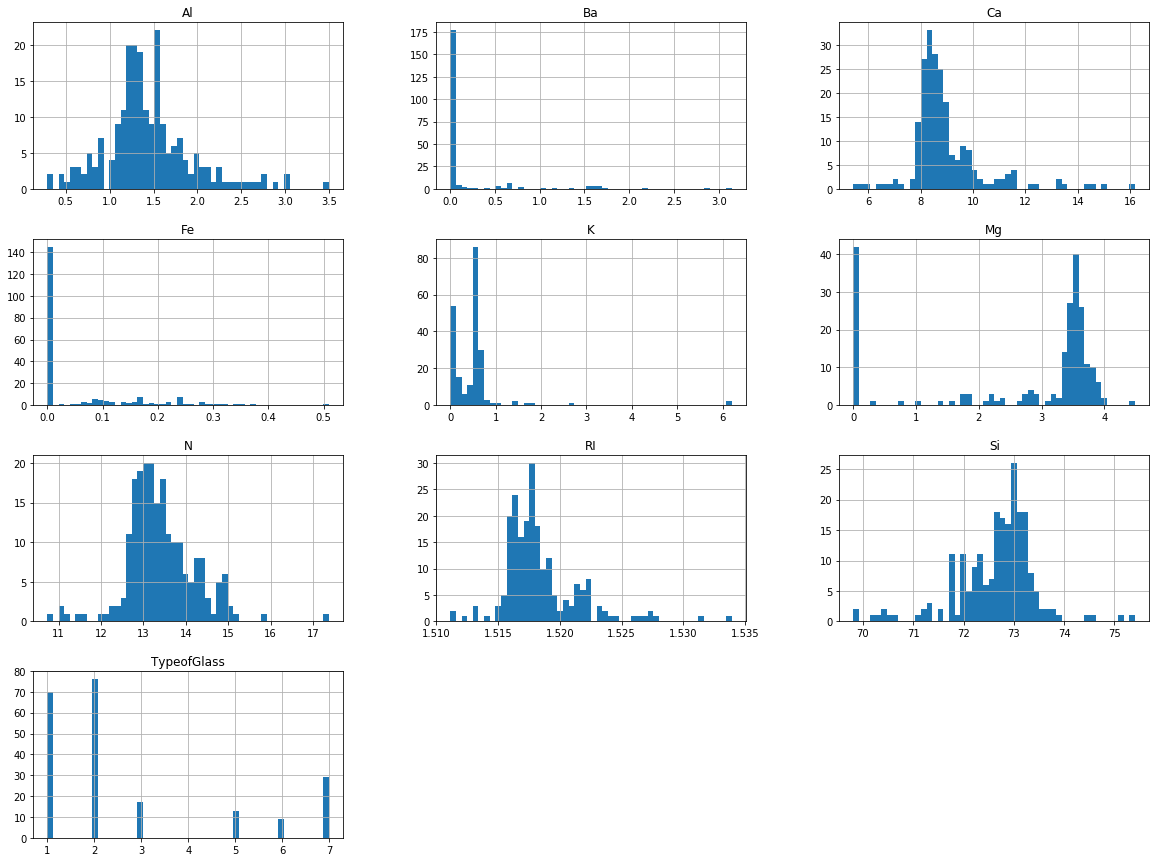

In [10]:

%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins = 50, figsize = (20,15))
plt.show()

In [11]:
X = data.drop('TypeofGlass', axis=1)
y = data.iloc[:,-1]
X.head()
y.head()

ID
1    1
2    1
3    1
4    1
5    1
Name: TypeofGlass, dtype: int64

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25)

In [13]:
#data.iloc[:,-1]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((160, 9), (54, 9), (160,), (54,))

In [14]:
#sns.pairplot(data)

In [15]:
X_train.head()

,RI,N,Mg,Al,Si,K,Ca,Ba,Fe
ID,,,,,,,,,
166,1.52171,11.56,1.88,1.56,72.86,0.47,11.41,0.00,0.00
132,1.52614,13.70,0.00,1.36,71.24,0.19,13.44,0.00,0.10
33,1.51775,12.85,3.48,1.23,72.97,0.61,8.56,0.09,0.22
14,1.51748,12.86,3.56,1.27,73.21,0.54,8.38,0.00,0.17
130,1.52020,13.98,1.35,1.63,71.76,0.39,10.56,0.00,0.18


In [16]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for training_indices, testing_indices in split.split(data, data["TypeofGlass"]):
        stratified_training_data = data.loc[training_indices]
        stratified_testing_data = data.loc[testing_indices]


#now check proportions in all the data set, training data set, and testing data set       
print(data["TypeofGlass"].value_counts()/len(data))

print(stratified_training_data["TypeofGlass"].value_counts()/len(stratified_training_data))
print(stratified_testing_data["TypeofGlass"].value_counts()/len(stratified_testing_data))

/Volumes/A/Basecamp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """


2    0.355140
1    0.327103
7    0.135514
3    0.079439
5    0.060748
6    0.042056
Name: TypeofGlass, dtype: float64
2.0    0.362573
1.0    0.321637
7.0    0.134503
3.0    0.081871
5.0    0.058480
6.0    0.035088
Name: TypeofGlass, dtype: float64
1    0.348837
2    0.325581
7    0.116279
6    0.069767
5    0.069767
3    0.069767
Name: TypeofGlass, dtype: float64


In [17]:
'''
X_train = stratified_training_data.drop('TypeofGlass', axis=1)
y_train = stratified_training_data.iloc[:,-1]
X_test = stratified_testing_data.drop('TypeofGlass', axis=1)
y_test = stratified_testing_data.iloc[:,-1]
'''


"\nX_train = stratified_training_data.drop('TypeofGlass', axis=1)\ny_train = stratified_training_data.iloc[:,-1]\nX_test = stratified_testing_data.drop('TypeofGlass', axis=1)\ny_test = stratified_testing_data.iloc[:,-1]\n"

In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [19]:

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('GB', GradientBoostingClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X_train_scale, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)


/Volumes/A/Basecamp/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Volumes/A/Basecamp/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Volumes/A/Basecamp/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Volumes/A/Basecamp/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Volumes/A/Basecamp/anaconda3/lib/python3.7/si

LR: 0.506250 (0.098623)
LDA: 0.612500 (0.100000)
KNN: 0.656250 (0.101743)
CART: 0.693750 (0.166419)
NB: 0.387500 (0.127475)
SVM: 0.468750 (0.097828)
GB: 0.712500 (0.145774)


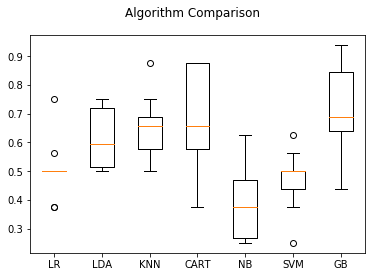

In [20]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

By Comparing the different classification models including logistic regression, Linear Discriminant model, KNN, Decision trees, naive Bayes, support vector machines and Gradient Boosting. I select the model which gives the best performance with 71.2% performance on the training dataset in a non-stratified sampling. In this case it is Gradient Boosting method. I took the model and tried to further optimize the hyperparameters. 

In [21]:

X_train_sub, X_validation_sub, y_train_sub, y_validation_sub = train_test_split(X_train_scale, y_train, random_state=0)

# train with Gradient Boosting algorithm
# compute the accuracy scores on train and validation sets when training with different learning rates

learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=5, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 0)
    gb.fit(X_train_sub, y_train_sub)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train_sub, y_train_sub)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_validation_sub, y_validation_sub)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.800
Accuracy score (validation): 0.700

Learning rate:  0.1
Accuracy score (training): 0.800
Accuracy score (validation): 0.700

Learning rate:  0.25
Accuracy score (training): 0.883
Accuracy score (validation): 0.625

Learning rate:  0.5
Accuracy score (training): 0.933
Accuracy score (validation): 0.525

Learning rate:  0.75
Accuracy score (training): 0.975
Accuracy score (validation): 0.625

Learning rate:  1
Accuracy score (training): 0.975
Accuracy score (validation): 0.600



In [22]:
# Output confusion matrix and classification report of Gradient Boosting algorithm on validation set

gb = GradientBoostingClassifier(n_estimators=5, learning_rate = 0.5, max_features=2, max_depth = 2, random_state = 0)
gb.fit(X_train_sub, y_train_sub)
predictions = gb.predict(X_validation_sub)

print("Confusion Matrix:")
print(confusion_matrix(y_validation_sub, predictions))
print()
print("Classification Report")
print(classification_report(y_validation_sub, predictions))

Confusion Matrix:
[[11  7  2  0  0  0]
 [ 0  8  2  0  0  1]
 [ 1  2  0  0  0  0]
 [ 0  0  0  1  0  0]
 [ 0  1  0  0  0  0]
 [ 0  0  1  1  1  1]]

Classification Report
              precision    recall  f1-score   support

           1       0.92      0.55      0.69        20
           2       0.44      0.73      0.55        11
           3       0.00      0.00      0.00         3
           5       0.50      1.00      0.67         1
           6       0.00      0.00      0.00         1
           7       0.50      0.25      0.33         4

   micro avg       0.53      0.53      0.53        40
   macro avg       0.39      0.42      0.37        40
weighted avg       0.64      0.53      0.55        40



In [23]:
gb_accuracy = gb.score(X_test_scale, y_test)*100     
print('The accuracy of the predicting Work class Missing Values with GradientBoosting Model is ' + str(gb_accuracy)+'%')

The accuracy of the predicting Work class Missing Values with GradientBoosting Model is 61.111111111111114%


In [24]:
testpredictions = gb.predict(X_test_scale)
len(testpredictions)

print("Confusion Matrix:")
print(confusion_matrix(y_test, testpredictions))
print()
print("Classification Report")
print(classification_report(y_test, testpredictions))
#confusion_matrix(y_test, testpredictions)

Confusion Matrix:
[[12  3  1  0  0  0]
 [ 7 14  1  0  1  1]
 [ 4  0  0  0  0  0]
 [ 0  2  0  1  0  0]
 [ 0  1  0  0  0  0]
 [ 0  0  0  0  0  6]]

Classification Report
              precision    recall  f1-score   support

           1       0.52      0.75      0.62        16
           2       0.70      0.58      0.64        24
           3       0.00      0.00      0.00         4
           5       1.00      0.33      0.50         3
           6       0.00      0.00      0.00         1
           7       0.86      1.00      0.92         6

   micro avg       0.61      0.61      0.61        54
   macro avg       0.51      0.44      0.45        54
weighted avg       0.62      0.61      0.60        54



In [25]:
'''test_keys = y_test.index
test_values = testpredictions
res = {test_keys[i]: test_values[i] for i in range(len(test_keys))}
# Printing resultant dictionary  
print ("Resultant dictionary is : " +  str(res)) 
'''

'test_keys = y_test.index\ntest_values = testpredictions\nres = {test_keys[i]: test_values[i] for i in range(len(test_keys))}\n# Printing resultant dictionary  \nprint ("Resultant dictionary is : " +  str(res)) \n'

I save the predictions in a csv file and use these predictions from the API, For every request, the request ID is matched with the ID in the file and the class is reported back via the URL through the REST API. 

In [26]:
yPred = pd.DataFrame(testpredictions, columns=['class'])
testIds = pd.DataFrame(y_test.index)
predictionsdataframe = pd.concat([testIds,yPred],axis=1)
predictionsdataframe.columns = ['id','classes']
predictionsdataframe.set_index('id')

,classes
id,
139,2
66,1
96,1
23,1
64,1
47,3
98,3
12,1
3,2


In [27]:
predictionsdataframe.to_csv('predictions.csv', index=False)
cpickle.dump(predictionsdataframe, open("predictions.pkl", "wb"))

The following snippet of code is used to test the API. I have sent 139 ID via post request and the API responds with the class, which can be checked in the predictions dataframe as well.

In [28]:
url = "http://localhost:5000/predictions"
data = json.dumps({'id':'139'}) 
r = requests.post(url, data)

print(r.json())

{'class': 2}
